### Building a decision tree classifier from scratch on loan dataset

In [1]:
#import libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Load dataset
dataset = pd.read_csv('./Datasets/loan_data.csv')
dataset = dataset.drop(columns=['Loan_ID'],axis=0)
dataset.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
#Check for NaN values
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 57.7+ KB


#### There are NaN values, we need to fill them. For now, lets fill the NaN values in categorical column with the most frequent occuring value and fill the numeric column with the median of that column

In [4]:
dataset['Gender'] = dataset['Gender'].fillna(dataset['Gender'].mode()[0])
dataset['Married'] = dataset['Married'].fillna(dataset['Married'].mode()[0])

In [5]:
#Dependents column
dataset['Dependents'].value_counts()

0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64

#### Fill this column also with maximum value count

In [6]:
dataset['Dependents'] = dataset['Dependents'].fillna(dataset['Dependents'].mode()[0])

In [7]:
#Same with the 'Self_Employed column'
dataset['Self_Employed'] = dataset['Self_Employed'].fillna(dataset['Self_Employed'].mode()[0])

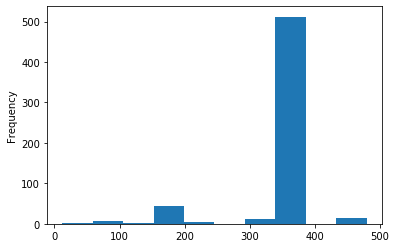

In [8]:
#Check the loan amount term column
dataset['Loan_Amount_Term'].plot(kind='hist')

#### The most frequent occuring value is 360.0, we will use this to fill the nan values in this column

In [9]:
dataset['Loan_Amount_Term'] = dataset['Loan_Amount_Term'].fillna(360.0)

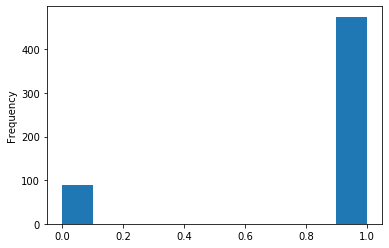

In [10]:
#Credit history column
dataset['Credit_History'].plot(kind='hist')

In [11]:
#Do the same as for 'Loan_amount_term' column
dataset['Credit_History'] = dataset['Credit_History'].fillna(1.0)

In [12]:
#Fill the loan amount column with the median of that column
dataset['LoanAmount'] = dataset['LoanAmount'].fillna(dataset['LoanAmount'].median())

In [13]:
#Check the dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    object 
 1   Married            614 non-null    object 
 2   Dependents         614 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      614 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         614 non-null    float64
 8   Loan_Amount_Term   614 non-null    float64
 9   Credit_History     614 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 57.7+ KB


#### All the NaN values are filled

In [14]:
#Build a class for node in a decision tree
#It has attributes as follows
#A left child, A right child, the data and split parameters if this node will be splitted
#The split parameters are - 'feature'-tells whicb feature is used to split the node
#                         - 'val'-tells the value at which the split is made, can be an object or float value
#                         - if the feature is numeric, then the left child contains the datapoints for which that feature is 
#                         - less than the threshold and right child contains datapoints greater than the threshold
#                         - if the feature is categorical, then the left child contains the datapoints where the feature
#                         - is equal to given val and right child contains the datapoints where that feature is not equal to that value
class Node:
    def __init__(self):
        self.left_child = None
        self.right_child = None
        self.data = None
        self.feature = None
        self.val = None
        self.leaf = False
    def set_left_child(self,node):
        self.left_child = node
    def set_right_child(self,node):
        self.right_child = node
    def set_data(self,data):
        self.data = data
    def set_split_params(self,feature,val):
        self.feature = feature
        self.val = val
        

In [15]:
#creating the functions for calculating the criteria for the splits
def shanon_entropy(data,target='Loan_Status'):
    probs = data[target].value_counts(normalize=True)
    entropy = 0
    for p in probs:
        entropy = entropy + (-1*(p*math.log2(p)))
    return entropy

def gini_impurity(data,target='Loan_Status'):
    probs = data[target].value_counts(normalize=True)
    impurity = 0
    for p in probs:
        impurity = impurity - (p*p)
    return impurity

def misclass_rate(data,target = 'Loan_Status'):
    probs = data[target].value_counts(normalize=True)
    return 1 - probs.max()   

#Stopping criteria by minimum number of samples and if a node is completely pure, min impurity by any of the criteria above can also be used
def stopping_criteria(node):
    if(len(node.data)<=5 or misclass_rate(node.data)<=0.01):
        return True
    else:
        return False

In [16]:
#Function for building the tree recursively
def build_tree(dataset,features,target='Loan_Status',criteria='Information Gain'):
    root = Node()
    root.set_data(dataset)
    #return the current node if stopping criteria is met
    if(stopping_criteria(root)):
        root.leaf=True
        return root
    allowed_cols = [] # allowable columns to be used to split
    allowed_col_gain = [] # list of 3-tuples of form (col_name,threshold,criteria_gain_after_splitting_on_this)
    for col in features:
        if((dataset[col].dtype.name=='object' and len(pd.unique(dataset[col]))>1) or dataset[col].dtype.name=='int64' or dataset[col].dtype.name=='float64'):
            allowed_cols.append(col)
    for col in allowed_cols:
        if(dataset[col].dtype.name=='object'):
            for val in list(pd.unique(dataset[col]))[:-1]:
                data_1 = dataset[dataset[col]==val]
                data_2 = dataset[dataset[col]!=val]
                if(criteria=='Information Gain'):
                    gain_after_split = shanon_entropy(dataset) - ((len(data_1)/len(dataset))*shanon_entropy(data_1))-((len(data_2)/len(dataset))*shanon_entropy(data_2))
                elif(criteria=='Gini'):
                    gain_after_split = gini_impurity(dataset)-(gini_impurity(data_1)+gini_impurity(data_2))
                elif(criteria=='misclassification rate'):
                    gain_after_split = misclass_rate(dataset)-(misclass_rate(data_1)+misclass_rate(data_2))
                allowed_col_gain.append((col,val,gain_after_split))
        #if the column is numeric
        else:
            temp_data = dataset.sort_values(col,ignore_index=True)
            changes = temp_data[target].ne(temp_data[target].shift().bfill()).astype(int)
            indices = changes[changes!=0].index.values#indices where the target variable changes its value 
            for idx in indices:
                threshold = 0.5*(temp_data.loc[idx-1,col]+temp_data.loc[idx,col])
                data_1 = dataset[dataset[col]<threshold]
                data_2 = dataset[dataset[col]>=threshold]
                if(criteria=='Information Gain'):
                    gain_after_split = shanon_entropy(dataset) - ((len(data_1)/len(dataset))*shanon_entropy(data_1))-((len(data_2)/len(dataset))*shanon_entropy(data_2))
                elif(criteria=='Gini'):
                    gain_after_split = gini_impurity(dataset)-(gini_impurity(data_1)+gini_impurity(data_2))
                elif(criteria=='misclassification rate'):
                    gain_after_split = misclass_rate(dataset)-(misclass_rate(data_1)+misclass_rate(data_2))
                allowed_col_gain.append((col,threshold,gain_after_split))
    #store the maximum gain result out of the 3-tuple list
    res_triplet = max(allowed_col_gain,key = lambda t:t[2])
    feature_to_split = res_triplet[0]
    value = res_triplet[1]
    root.set_split_params(feature_to_split,value)
    if(dataset[feature_to_split].dtype.name=='object'):
        dataset_left = dataset[dataset[feature_to_split]==value]
        dataset_right = dataset[dataset[feature_to_split]!=value]
    else:
        dataset_left = dataset[dataset[feature_to_split]<value]
        dataset_right = dataset[dataset[feature_to_split]>=value]
    left_child = build_tree(dataset_left,features)
    right_child = build_tree(dataset_right,features)
    root.set_left_child(left_child)
    root.set_right_child(right_child)
    return root 

In [17]:
features = list(dataset.columns.values)[:-1]
tree_clf = build_tree(dataset,features)

In [18]:
#predicting new datapoint
def predict(datapoint,node,target='Loan_Status'):
    if(node.leaf):
        return node.data[target].mode()[0]
    feature_to_split = node.feature
    value = node.val
    if(node.data[feature_to_split].dtype.name=='object'):
        if(datapoint.loc[0,feature_to_split]==value):
            return predict(datapoint,node.left_child)
        else:
            return predict(datapoint,node.right_child)
    else:
        if(datapoint.loc[0,feature_to_split]<value):
            return predict(datapoint,node.left_child)
        else:
            return predict(datapoint,node.right_child)
        
        

In [19]:
datapoint = pd.DataFrame(data={'Gender':['Male'],'Married':['No'],'Dependents':['2'],'Education':['Graduate'],'Self_Employed':['Yes'],'ApplicantIncome':[3102],'CoapplicantIncome':[2138.0],'LoanAmount':[86.0],'Loan_Amount_Term':[200.0],'Credit_History':[1.0],'Property_Area':['Urban']})
print(predict(datapoint,tree_clf))

Y


#### Means the loan is approved for the given datapoint

In [43]:
#Computing training accuracy
train_preds = []
for i in range(len(dataset)):
    pred = predict(dataset.loc[[i],features].reset_index(),tree_clf)
    train_preds.append(pred)
train_preds = np.array(train_preds)
print(((dataset['Loan_Status'].values==train_preds).sum())/(len(dataset)))

0.9462540716612378


#### 94 % training accuracy